# Olist Data Preparation
*By Rafael LeRoy*

## Introduction

Our goal for this task is to clean and prepare the data for usage in a dashboard.

Our Dashboard will consist of three views:

**Orders:** 
* Which customers ordered the most
* Which geographical states did most orders come from
* How many orders were there per month

**Sellers:**
* Which sellers had the highest sales revenue
* Which geographical states did most sellers come from
* How many sellers were there per month

**Products:**
* Which product categories sold the most
* Which individual products sold the most

We will prepare the data in a way that will most suitably accommodate these views.

## Getting an overview of the Data

Before we begin any preparation, it is essential that we get an overview of the datasets.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
from googletrans import Translator

pd.set_option('display.max_columns', 500)
plt.rcParams['axes.grid'] = True

customers = pd.read_csv('/content/olist_customers_dataset.csv')
sellers = pd.read_csv('/content/olist_sellers_dataset.csv')
products = pd.read_csv('/content/olist_products_dataset.csv')
order_items = pd.read_csv('/content/olist_order_items_dataset.csv')
orders = pd.read_csv('/content/olist_orders_dataset.csv')
order_payments = pd.read_csv('/content/olist_order_payments_dataset.csv')
reviews = pd.read_csv('/content/olist_order_reviews_dataset.csv')

In [3]:
# Lets summarize the null values and duplicate values in our datasets

def series_describer(df):
    null_dic = df.isna().sum().to_dict()
    null_columns = ', '.join([i for i in null_dic if null_dic[i] != 0])
    null_percentage = len(df[df.isnull().any(axis = 1)]) / len(df) * 100
    return [len(df.columns), len(df), df.duplicated().sum(), len(df[df.isnull().any(axis = 1)]), null_percentage, null_columns]

df = pd.DataFrame([series_describer(i) for i in [customers, sellers, products, order_items, orders, order_payments, reviews]],
                  columns = ['Number Of columns', 'Number of Rows', 'Duplicated Rows', 'Number of Nulls','Null_percentage','Null Columns'],
                  index = ['customers', 'sellers', 'products', 'order_items','orders', 'order_payments', 'reviews'])

df.style.background_gradient()

,Number Of columns,Number of Rows,Duplicated Rows,Number of Nulls,Null_percentage,Null Columns
customers,5,99441,0,0,0.000000,
sellers,4,3095,0,0,0.000000,
products,9,32951,0,611,1.854268,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
order_items,7,112650,0,0,0.000000,
orders,8,99441,0,2980,2.996752,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
order_payments,5,103886,0,0,0.000000,
reviews,7,99224,0,89385,90.084052,"review_comment_title, review_comment_message"


The table above shows us the number of rows with at least one null value. Other than the reviews dataset, which we will deal with later, this data seems to have very few null values meaning the data can be used to create an accurate analysis.

## Preparing the products dataset

In [4]:
# Lets view the Null values in this dataset
products.isna().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

From the cell above we can see the `product_name_lenght` and `product_description_lenght` are misspelt so we will correct them.

In [5]:
products.rename(columns = {'product_name_lenght': 'product_name_length',
                           'product_description_lenght': 'product_description_length'}, inplace = True)

We can also see the number of null values for every column in our dataset. The last four columns contain quantitative data, so the null values can be imputed with either the median or the mean.

Let’s explore the best option for imputation.

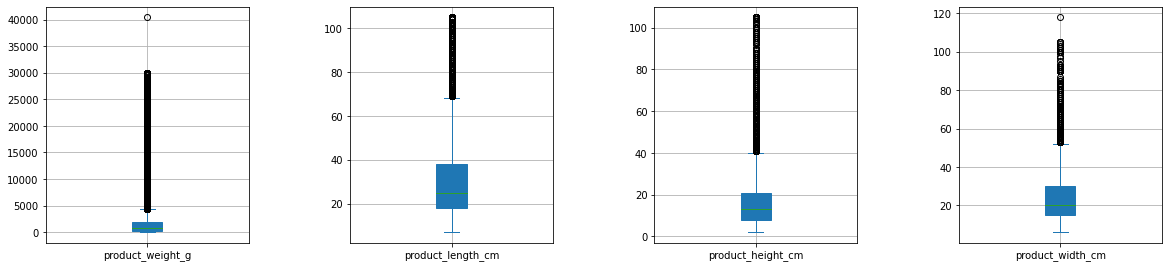

In [6]:
products_to_plot = products[['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']]
products_to_plot.plot(subplots=True, layout=(4,4), kind='box', figsize=(20,20), patch_artist = True)
plt.grid()
plt.subplots_adjust(wspace=0.5)
plt.show();

The boxplots above show that all four columns have many outliers creating a rightward skew. As we don’t want these outliers to be represented within our average, the best option would be to impute the median.

In [7]:
cols = ['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']

products[cols] = products[cols].fillna(products[cols].median())

products.isna().sum()

product_id                      0
product_category_name         610
product_name_length           610
product_description_length    610
product_photos_qty            610
product_weight_g                0
product_length_cm               0
product_height_cm               0
product_width_cm                0
dtype: int64

We now have to move on to the columns with the nominal data. This is where things get a bit tricky. As the data is qualitative, we can't impute the mean or median, and we would have to use the mode. One of the main objectives of the task assigned to us is to analyse the performance of the different products. This means that the accuracy of the this dataset is critical for this analysis. For this reason, I will drop these rows instead of imputing the mode.

In [8]:
products.dropna(inplace = True)
products.isna().sum()

product_id                    0
product_category_name         0
product_name_length           0
product_description_length    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
dtype: int64

**Now that the null values have been dealt with, we can move on to feature engineering.**

In [9]:
#Lets first take a look at the unique values for every column.
{k: products[k].unique() for k in products.columns}

{'product_category_name': array(['perfumaria', 'artes', 'esporte_lazer', 'bebes',
        'utilidades_domesticas', 'instrumentos_musicais', 'cool_stuff',
        'moveis_decoracao', 'eletrodomesticos', 'brinquedos',
        'cama_mesa_banho', 'construcao_ferramentas_seguranca',
        'informatica_acessorios', 'beleza_saude', 'malas_acessorios',
        'ferramentas_jardim', 'moveis_escritorio', 'automotivo',
        'eletronicos', 'fashion_calcados', 'telefonia', 'papelaria',
        'fashion_bolsas_e_acessorios', 'pcs', 'casa_construcao',
        'relogios_presentes', 'construcao_ferramentas_construcao',
        'pet_shop', 'eletroportateis', 'agro_industria_e_comercio',
        'moveis_sala', 'sinalizacao_e_seguranca', 'climatizacao',
        'consoles_games', 'livros_interesse_geral',
        'construcao_ferramentas_ferramentas',
        'fashion_underwear_e_moda_praia', 'fashion_roupa_masculina',
        'moveis_cozinha_area_de_servico_jantar_e_jardim',
        'industria_comerci

**The unique values above show us which columns we could engineer:**
 * The values in the `product_category_name` column are in portuguese. We should translate these to english

In [10]:
# Cleaning up the product category names to remove the underscores
products['product_category_name'] = products['product_category_name'].str.replace('_', ' ')

#Translating from Portugease to English
translator = Translator()
translated_dic = {i: translator.translate(i, dest = 'en').text for i in products['product_category_name'].unique()}
translated_dic

{'agro industria e comercio': 'agro industry and trade',
 'alimentos': 'foods',
 'alimentos bebidas': 'Drink foods',
 'artes': 'artes',
 'artes e artesanato': 'Arts and Crafts',
 'artigos de festas': 'party articles',
 'artigos de natal': 'Christmas articles',
 'audio': 'audio',
 'automotivo': 'automotive',
 'bebes': 'babies',
 'bebidas': 'drinks',
 'beleza saude': 'HEALTH BEAUTY',
 'brinquedos': 'toys',
 'cama mesa banho': 'bed table bath',
 'casa conforto': 'comfort house',
 'casa conforto 2': 'Comfort 2 house',
 'casa construcao': 'Casa Construcao',
 'cds dvds musicais': 'cds dvds musicais',
 'cine foto': 'Photo cinema',
 'climatizacao': 'climatization',
 'consoles games': 'consoles games',
 'construcao ferramentas construcao': 'Construction Tools Construction',
 'construcao ferramentas ferramentas': 'Construction Tools Tools',
 'construcao ferramentas iluminacao': 'Construction Tools Illumination',
 'construcao ferramentas jardim': 'Construction Tools Garden',
 'construcao ferramen

In [11]:
# Some of the values have incorrectly translated so we will change those manually

translated_dic['informatica acessorios'] = 'Computer Accessories'
translated_dic['malas acessorios'] = 'Accessory Bags'
translated_dic['fashion calcados'] = 'Fashion Shoes'
translated_dic['telefonia'] = 'Telephone'
translated_dic['eletroportateis'] = 'Small Appliances'
translated_dic['Climatizacao'] = 'Air Conditioning'
translated_dic['telefonia fixa'] = 'Telephony Fix'
translated_dic['eletrodomesticos 2'] = 'Home Appliances 2'
translated_dic['portateis casa forno e cafe'] = 'Portable Home Oven and Coffee'
translated_dic['portateis cozinha e preparadores de alimentos'] = 'Portable Cooking and Food Preparers'
translated_dic['flores'] = 'Flowers'
translated_dic['moveis colchao e estofado'] = 'mattress and upholstery furniture'

translated_dic =  {k:v.title() for k,v in translated_dic.items()}

products['product_category_name'] = products['product_category_name'].map(translated_dic)

**Finally, we will check for any irregular values that may need to be removed**

If the data has any extreme outliers or any impossible values, they will have to be removed.

product_name_length           5.0
product_description_length    4.0
product_photos_qty            1.0
product_weight_g              0.0
product_length_cm             7.0
product_height_cm             2.0
product_width_cm              6.0
dtype: float64


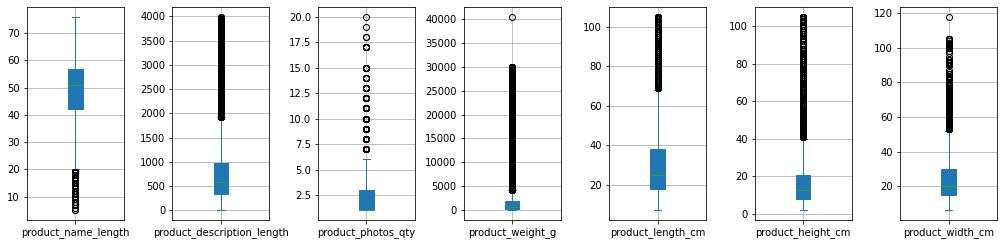

In [12]:
quantative_rows = products.iloc[:, 2:]
quantative_rows.plot(subplots=True, layout=(4,8), kind='box', figsize=(20,18), patch_artist=True)
plt.subplots_adjust(wspace=0.5)
print(quantative_rows.min(axis=0))

From the Boxplots above we can see that while there are a lot of outliars, given the context of the columns, none are inexplainable. 

When looking at the minimum value for each column however, we can see that `product_weight_g` has a minimum of 0 which should be impossible. Lets explore the `product_weight_g` column to try and solve the problem.

In [13]:
products[products['product_weight_g'] == 0]

,product_id,product_category_name,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
9769,81781c0fed9fe1ad6e8c81fca1e1cb08,Bed Table Bath,51.0,529.0,1.0,0.0,30.0,25.0,30.0
13683,8038040ee2a71048d4bdbbdc985b69ab,Bed Table Bath,48.0,528.0,1.0,0.0,30.0,25.0,30.0
14997,36ba42dd187055e1fbe943b2d11430ca,Bed Table Bath,53.0,528.0,1.0,0.0,30.0,25.0,30.0
32079,e673e90efa65a5409ff4196c038bb5af,Bed Table Bath,53.0,528.0,1.0,0.0,30.0,25.0,30.0


The cell above shows every row in which the `product_weight_g` is 0. It is impossible for a physical object to have no weight therefore we will remove these rows.

In [14]:
products = products[products['product_weight_g'] == 0]

## Preparing the sellers dataset

In [15]:
# First lets view the Null values in this dataset
sellers.isna().sum()

seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

As there are no null values, we can move straight onto feature engineering.

In [16]:
#Lets first take a look at the unique values for every column.
{k: sellers[k].unique() for k in sellers.columns}

{'seller_city': array(['campinas', 'mogi guacu', 'rio de janeiro', 'sao paulo',
        'braganca paulista', 'brejao', 'penapolis', 'curitiba', 'anapolis',
        'itirapina', 'tubarao', 'lauro de freitas', 'imbituba', 'brasilia',
        'porto seguro', 'guaruja', 'tabatinga', 'salto', 'tres de maio',
        'belo horizonte', 'arapongas', 'sao bernardo do campo', 'tatui',
        'garopaba', 'camanducaia', 'tupa', 'guarulhos',
        'sao jose dos pinhais', 'sao ludgero', 'sao jose', 'piracicaba',
        'porto alegre', 'congonhal', 'santo andre', 'osasco', 'valinhos',
        'joinville', 'saquarema', 'barra velha', 'petropolis',
        'santo antonio da patrulha', 'ponta grossa', 'santana de parnaiba',
        'sao carlos', 'ibitinga', 'barueri', 'caxias do sul', 'araguari',
        'contagem', 'jaragua do sul', 'lages - sc', 'bento goncalves',
        'catanduva', 'ribeirao pires', 'jaboticabal', 'echapora', 'cotia',
        'rio do sul', 'sorocaba', 'pradopolis', 'itaborai', 

**The unique values above show us which columns we could engineer:**
 * The values in the seller_state column have the abbreviations for the state names. To create map charts in Tableau, we would have to replace these abbreviations with the state’s full name

In [17]:
# Scraping the State names from wikipedia
brazilian_cities_url = 'https://en.wikipedia.org/wiki/Federative_units_of_Brazil'
res = requests.get(brazilian_cities_url)
soup = BeautifulSoup(res.text, "html.parser")
table = soup.find_all('table')
state_names = pd.read_html(str(table[1]))[0]

dic = pd.Series(state_names['Flag and name'].values,index=state_names['Code']).to_dict()
sellers['seller_state'] = sellers['seller_state'].map(dic)

In [18]:
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,São Paulo
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,São Paulo
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,Rio de Janeiro
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,São Paulo
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,São Paulo


## Preparing the customers dataset

In [19]:
# First lets view the Null values in this dataset
customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

As there are no null values, we can move straight onto feature engineering.

In [20]:
# Lets take a look at the unique values for every column.
{k: customers[k].unique() for k in customers.columns}

{'customer_city': array(['franca', 'sao bernardo do campo', 'sao paulo', ...,
        'monte bonito', 'sao rafael', 'eugenio de castro'], dtype=object),
 'customer_id': array(['06b8999e2fba1a1fbc88172c00ba8bc7',
        '18955e83d337fd6b2def6b18a428ac77',
        '4e7b3e00288586ebd08712fdd0374a03', ...,
        '5e28dfe12db7fb50a4b2f691faecea5e',
        '56b18e2166679b8a959d72dd06da27f9',
        '274fa6071e5e17fe303b9748641082c8'], dtype=object),
 'customer_state': array(['SP', 'SC', 'MG', 'PR', 'RJ', 'RS', 'PA', 'GO', 'ES', 'BA', 'MA',
        'MS', 'CE', 'DF', 'RN', 'PE', 'MT', 'AM', 'AP', 'AL', 'RO', 'PB',
        'TO', 'PI', 'AC', 'SE', 'RR'], dtype=object),
 'customer_unique_id': array(['861eff4711a542e4b93843c6dd7febb0',
        '290c77bc529b7ac935b93aa66c333dc3',
        '060e732b5b29e8181a18229c7b0b2b5e', ...,
        'e9f50caf99f032f0bf3c55141f019d99',
        '73c2643a0a458b49f58cea58833b192e',
        '84732c5050c01db9b23e19ba39899398'], dtype=object),
 'customer_zip_code_

**The unique values above show us which columns we could engineer:**
 * Much like the `seller_state` column, the `customer_state` column also has the abbreviation for the state names. We will have to change these
 * Using the `customer_unique_id` column, we could create a boolean column which would be used to find returning customers.

In [21]:
# Using the previously defined dictionary, we can change the customer_state values
customers['customer_state'] = customers['customer_state'].map(dic)
customers['customer_state'].head()

0    São Paulo
1    São Paulo
2    São Paulo
3    São Paulo
4    São Paulo
Name: customer_state, dtype: object

In [22]:
# Creating a column to find returning customers
customers['repeat_customer'] = customers['customer_unique_id'].duplicated(keep = False)

## Preparing the order_items dataset

In [23]:
# First lets view the Null values in this dataset
order_items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

As there are no null values, we can move straight onto feature engineering.

In [24]:
{k: order_items[k].unique() for k in order_items.columns}

{'freight_value': array([ 13.29,  19.93,  17.87, ..., 127.55,   6.79,   6.37]),
 'order_id': array(['00010242fe8c5a6d1ba2dd792cb16214',
        '00018f77f2f0320c557190d7a144bdd3',
        '000229ec398224ef6ca0657da4fc703e', ...,
        'fffce4705a9662cd70adb13d4a31832d',
        'fffe18544ffabc95dfada21779c9644f',
        'fffe41c64501cc87c801fd61db3f6244'], dtype=object),
 'order_item_id': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21]),
 'price': array([ 58.9 , 239.9 , 199.  , ...,   7.84, 399.85, 736.  ]),
 'product_id': array(['4244733e06e7ecb4970a6e2683c13e61',
        'e5f2d52b802189ee658865ca93d83a8f',
        'c777355d18b72b67abbeef9df44fd0fd', ...,
        'dd469c03ad67e201bc2179ef077dcd48',
        'bbe7651fef80287a816ead73f065fc4b',
        '350688d9dc1e75ff97be326363655e01'], dtype=object),
 'seller_id': array(['48436dade18ac8b2bce089ec2a041202',
        'dd7ddc04e1b6c2c614352b383efe2d36',
        '5b51032eddd242adc84c38a

**The unique values above show us which columns we could engineer:**
 * We will have to check if the `shipping_limit_date` is in a format that Tableau supports. yyyy-MM-dd HH:mm:ss is supported by Tableau therefore there is no issue with that column.

**Finally, we will check for any irregular values that may need to be removed**

If the data has any extreme outliers or any impossible values then they will have to be removed

,min_value,max_value
price,0.85,6735.0
freight_value,0.0,409.68
Year,2016,2020


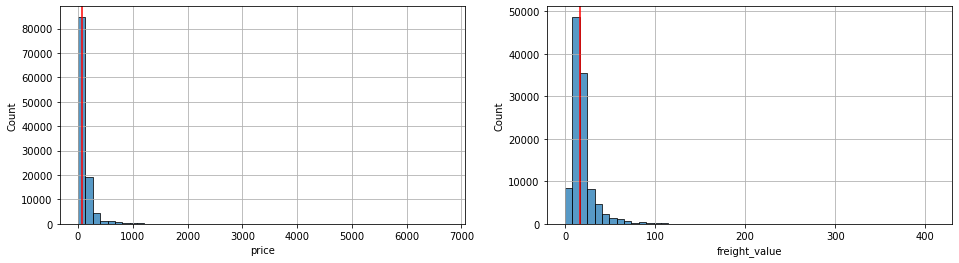

In [25]:
years = order_items['shipping_limit_date'].apply(lambda x: x.split('-')[0])
quantative_rows = order_items.loc[:,['price', 'freight_value']]
quantative_rows['Year'] = years

fig, ax = plt.subplots(1, 2, figsize = (16, 4))
sns.histplot(order_items['price'], ax = ax[0], bins = 50)
sns.histplot(order_items['freight_value'], ax = ax[1], bins = 50)
ax[0].axvline(order_items['price'].median(), color = 'red')
ax[1].axvline(order_items['freight_value'].median(), color = 'red')
fig.show()
pd.DataFrame({'min_value': quantative_rows.min(axis = 0), 'max_value' :quantative_rows.max(axis = 0)})

Above, we have plotted histograms for the `price` and `freight_value` columns. While the charts for both columns have a rightward skew with many outliers, the data tends to show what we would expect, with most orders being less than 500 dollars and most shipping costs being below 50 dollars.
We have also displayed both columns’ minimum and maximum values, and there are no inexplicable values.


## Preparing the orders dataset

In [26]:
# Lets view the Null values in this dataset
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

This dataset seems to have a large number of null values. Lets try and work out why this is.

In [27]:
# Viewing the null values in the order_delivered_customer_date column

orders[orders['order_delivered_customer_date'].isna()]['order_status'].value_counts()

shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
delivered         8
created           5
approved          2
Name: order_status, dtype: int64

From further inspection, we can see the null values in this dataset fall almost entirely on orders which have not yet been delivered. As you can't provide information on an event that is yet to occur, some of the values have been left blank. We now know that these nulls aren't due to any error, so we can leave them. 

There is, however, no explanation for the null values where the `order_status` is delivered, so we will remove those rows.


In [28]:
drop_index = orders[(orders['order_status'] == 'delivered') & (orders.isnull().any(axis = 1))].index
orders = orders.drop(drop_index).reindex()

## Preparing the order_payments dataset

In [29]:
# Lets view the Null values in this dataset
order_payments.isna().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

The are no null values so lets move onto checking for any outliars

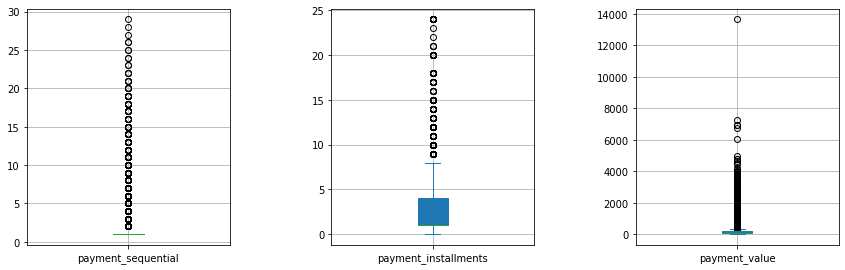

,min_value,max_value,median_value,mean_value
payment_sequential,1.0,29.00,1.0,1.092679
payment_installments,0.0,24.00,1.0,2.853349
payment_value,0.0,13664.08,100.0,154.100380


In [30]:
quantative_rows = order_payments[['payment_sequential', 'payment_installments', 'payment_value']]
quantative_rows.plot(subplots=True, layout=(4,4), kind='box', figsize=(20,20), patch_artist = True)
plt.grid()
plt.subplots_adjust(wspace=0.5)
plt.show();

pd.DataFrame({'min_value': quantative_rows.min(axis = 0), 'max_value' :quantative_rows.max(axis = 0),
              'median_value' :quantative_rows.median(axis = 0), 'mean_value': quantative_rows.mean(axis = 0)})

While our boxplots show many outliers for every column, given the context there shouldn't be any cause for concern.

What should be looked at however is the `payment_value` and `payment_installments` columns having  minimum values of 0.

In [31]:
# Isolate rows for which either payment_sequential or payment_value is 0
order_payments[(order_payments['payment_value'] == 0) | (order_payments['payment_installments'] == 0)]

,order_id,payment_sequential,payment_type,payment_installments,payment_value
19922,8bcbe01d44d147f901cd3192671144db,4,voucher,1,0.00
36822,fa65dad1b0e818e3ccc5cb0e39231352,14,voucher,1,0.00
43744,6ccb433e00daae1283ccc956189c82ae,4,voucher,1,0.00
46982,744bade1fcf9ff3f31d860ace076d422,2,credit_card,0,58.69
51280,4637ca194b6387e2d538dc89b124b0ee,1,not_defined,1,0.00
57411,00b1cb0320190ca0daa2c88b35206009,1,not_defined,1,0.00
62674,45ed6e85398a87c253db47c2d9f48216,3,voucher,1,0.00
77885,fa65dad1b0e818e3ccc5cb0e39231352,13,voucher,1,0.00
79014,1a57108394169c0b47d8f876acc9ba2d,2,credit_card,0,129.94
94427,c8c528189310eaa44a745b8d9d26908b,1,not_defined,1,0.00


From the cell above, we can see that for the rows in which the `payment_value` is 0, the `payment_type` is either a voucher or some unspecified payment_type, meaning that the customer not spending any money is viable. For that reason, we will leave these rows.

There is no explanation, however, for the `payment_installments` being 0 so we will drop those rows.

In [32]:
order_payments = order_payments[order_payments['payment_installments'] != 0]

## Preparing the reviews_dataset

In [33]:
# Lets view the Null values in this dataset
reviews.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

The null values in this dataframe are only in the `review_comment_title` column and the `review_comment_message` section. It is plausible that leaving a message to go with your review is optional meaning that a lot of people would have just left this section blank. Because of this, we will leave these null values.

In [34]:
answer_year = reviews['review_answer_timestamp'].apply(lambda x: float(x.split('-')[0]))
creation_year = reviews['review_creation_date'].apply(lambda x: float(x.split('-')[0]))

quantative_rows = reviews.loc[:, ['review_score']]
quantative_rows['answer_year'] = answer_year
quantative_rows['creation_year'] = creation_year

pd.DataFrame({'min' : quantative_rows.min(axis = 0), 'max': quantative_rows.max(axis = 0),
             'mean': quantative_rows.mean(axis = 0), 'Median': quantative_rows.median(axis = 0)})

,min,max,mean,Median
review_score,1.0,5.0,4.086421,5.0
answer_year,2016.0,2018.0,2017.569741,2018.0
creation_year,2016.0,2018.0,2017.562757,2018.0


## Merging the Datasets

In [35]:
olist = customers.merge(orders, on = 'customer_id', how = 'left')
olist = olist.merge(order_payments, on = 'order_id', how = 'left')
olist = olist.merge(order_items, on = 'order_id', how = 'left')
olist = olist.merge(products, on = 'product_id', how = 'left')
olist = olist.merge(sellers, on = 'seller_id', how = 'left')
olist = olist.merge(reviews, on = 'order_id', how = 'left')

## We have now successfully prepared the data